# Сборный проект-2

**Описание проекта:**

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Описание данных:**

_**Каждая запись в логе — это действие пользователя, или событие.**_

_**EventName**_ — название события;

_**DeviceIDHash**_ — уникальный идентификатор пользователя;

_**EventTimestamp**_ — время события;

_**ExpId**_ — номер эксперимента: _246 и 247 — контрольные группы, а 248 — экспериментальная._

    План работы:
    
    1) Предобработка данных
    
    2) Проверка данных
    
    3) Изучение воронки событий
    
    4) Анализ результатов эксперимента.

## Предобработка данных

    Откройте файл с данными и изучите общую информацию;
    Замените названия столбцов на удобные для вас;
    Проверьте пропуски и типы данных. Откорректируйте, если нужно;
    Добавьте столбец даты и времени, а также отдельный столбец дат

In [1]:
# используемые библиотеки

import os
from pathlib import Path
import pandas as pd
import datetime as dt
import seaborn as sns
import math
from scipy import stats as st
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
ROOT_DIR = Path(os.path.abspath("__file__")).parent.parent

In [3]:
data = pd.read_csv(ROOT_DIR / 'datasets/logs_exp.csv', sep='\t')

In [4]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# переименование названий столбцов:

data.columns = ['event_name', 'user_id', 'timestamp', 'group']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   timestamp   244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
# поиск пропусков:

data.isna().sum()

event_name    0
user_id       0
timestamp     0
group         0
dtype: int64

In [7]:
# создание столбцов с датой:

data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['datetime'].dt.date.astype('datetime64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   timestamp   244126 non-null  int64         
 3   group       244126 non-null  int64         
 4   datetime    244126 non-null  datetime64[ns]
 5   date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [8]:
# дубликаты:

display(data.duplicated(['event_name', 'user_id', 'timestamp', 'group', 'datetime', 'date']).sum())

413

In [9]:
# удаляем дубликаты:

data = data.drop_duplicates()
display(data.duplicated(['event_name', 'user_id', 'timestamp', 'group', 'datetime', 'date']).sum())

0

### Подытог:
    Добавлено 2 новых столбца с датами, типы данных корректны, пропуски не обнаружены, дубликаты удалены.
    Отредактированы названия столбцов.

## Проверка данных
    1) Сколько всего событий в логе?
    2) Сколько всего пользователей в логе?
    3) Сколько в среднем событий приходится на пользователя?
    4) Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
    5) Много ли событий и пользователей вы потеряли, отбросив старые данные?
    6) Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [10]:
# событий в логе:

display(data['event_name'].value_counts())
event_cnt = data['event_name'].count()
print('Всего событий', event_cnt)

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Всего событий 243713


In [11]:
# пользователей в логе:

user_cnt = data['user_id'].nunique()
print('Всего пользователей', user_cnt)

Всего пользователей 7551


In [12]:
# в среднем на пользователя приходится событий:

users_event = data.groupby('user_id')['event_name'].count().median()
print('В среднем событий приходится на пользователя', users_event)

В среднем событий приходится на пользователя 20.0


In [13]:
# данными за какой период вы располагаете?

print(f"Данные предоставлены с {data['date'].min()} по {data['date'].max()}")

Данные предоставлены с 2019-07-25 00:00:00 по 2019-08-07 00:00:00


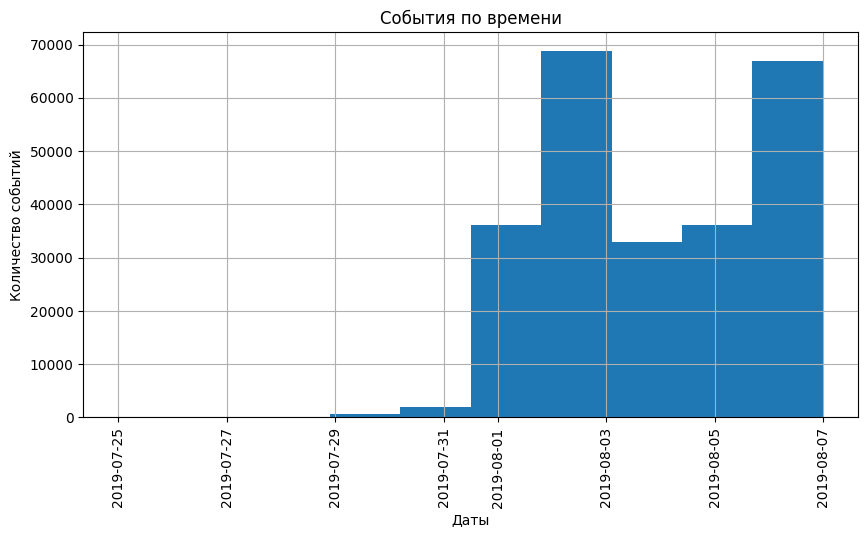

In [14]:
# гистограмма по дате и времени:

plt.hist(data['date'], bins=10)
plt.title('События по времени')
plt.xlabel('Даты')
plt.ylabel('Количество событий')
plt.xticks(rotation='vertical')
plt.grid()
plt.show()

**Пока видим существенное количество событий только в августе, рассмотрим данные подробнее:**

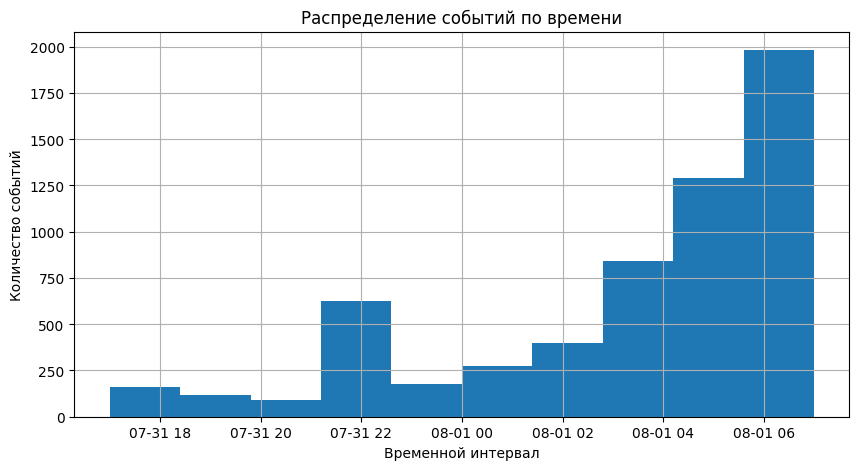

In [15]:
plt.hist(data['datetime'], bins=10, range=('2019-07-31 17:00:00', '2019-08-01 07:00:00'))
plt.xlabel('Временной интервал')
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени')
plt.grid()
plt.show()

**Можем зафиксировать возврастание количества событий с 21:00 31 июля, возможно, был рекламный запуск**

    Будем считать, что реальные данные с вечера 31 июля по 7 августа.
    Всё, что до, не будет приниматься к анализу - удалим:

In [16]:
data = data[data['datetime'] > '2019-07-31 21:00:00'].reset_index(drop=True)
data.sort_values(by='datetime')

,event_name,user_id,timestamp,group,datetime,date
0,MainScreenAppear,7701922487875823903,1564606857,247,2019-07-31 21:00:57,2019-07-31
1,MainScreenAppear,2539077412200498909,1564606905,247,2019-07-31 21:01:45,2019-07-31
2,OffersScreenAppear,3286987355161301427,1564606941,248,2019-07-31 21:02:21,2019-07-31
3,OffersScreenAppear,3187166762535343300,1564606943,247,2019-07-31 21:02:23,2019-07-31
4,MainScreenAppear,1118952406011435924,1564607005,248,2019-07-31 21:03:25,2019-07-31
...,...,...,...,...,...,...
241719,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
241720,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
241721,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
241722,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [17]:
# Много ли событий и пользователей утеряны после отсева старых данных?

new_user_cnt = data['user_id'].nunique()
print(f'До среза было пользователей {user_cnt}, сейчас их {new_user_cnt}. Потери составили {round((user_cnt - new_user_cnt) / user_cnt * 100, 2)}% это {user_cnt - new_user_cnt} пользователей')

new_event_cnt = data['event_name'].count()
print(f'До среза было событий {event_cnt}, сейчас их {new_event_cnt}. Потери составили {round((event_cnt - new_event_cnt) / event_cnt * 100, 2)}% это {event_cnt - new_event_cnt} событий')

До среза было пользователей 7551, сейчас их 7538. Потери составили 0.17% это 13 пользователей
До среза было событий 243713, сейчас их 241724. Потери составили 0.82% это 1989 событий


**Мы не взяли во внимание менее 1% событий от 13 пользователей, что будем считать незначительными потерями.**

In [18]:
# Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп

data.groupby('group')['user_id'].nunique()

group
246    2484
247    2517
248    2537
Name: user_id, dtype: int64

**Пользователи присутствуют во всех группах теста и их количество приблизительно одно.**

### Подытог:
    При проверке данных мы узнали, что изначально в таблице было 243’713 событий от 7’551 пользователя, а в среднем на одного пользователя приходилось 20 событий.
    
    Далее мы выявили, что к анализу допустим период с 31 июля с 21:00 по 7 августа. Мы не взяли во внимание данные с 25 июля по 31 июля до 21:00, что привело к незначительным потерям событий — 0.82%.
    
    В каждой группе около 2’500 пользователей.

## Изучение воронки событий

    1) Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
    2) Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
    3) Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
    4) По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
    5) На каком шаге теряете больше всего пользователей?
    6) Какая доля пользователей доходит от первого события до оплаты?

In [19]:
# события в логах по частоте:

data['event_name'].value_counts()

MainScreenAppear           117889
OffersScreenAppear          46531
CartScreenAppear            42343
PaymentScreenSuccessful     33951
Tutorial                     1010
Name: event_name, dtype: int64

**_Самое часто событие -_ Появление главного экрана, далее: Появление экрана предложений, Появление экрана корзины, Экран оплаты пройден успешно и Руководство.**

In [20]:
# сколько пользователей совершали каждое из этих событий:

events_user = data.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
events_user.columns = ['count_events', 'users']
events_user['users_part_events (%)'] = (events_user['users'] / new_user_cnt * 100).round(1)
events_user.reset_index(inplace=True)

**Практически все пользователи хотя бы раз открывали _главный экран - их 98.5%_**

    экран предложений - 61%
    экран корзины - 49.6%
    экран оплаты - 47%
    руководство - 11.2%.

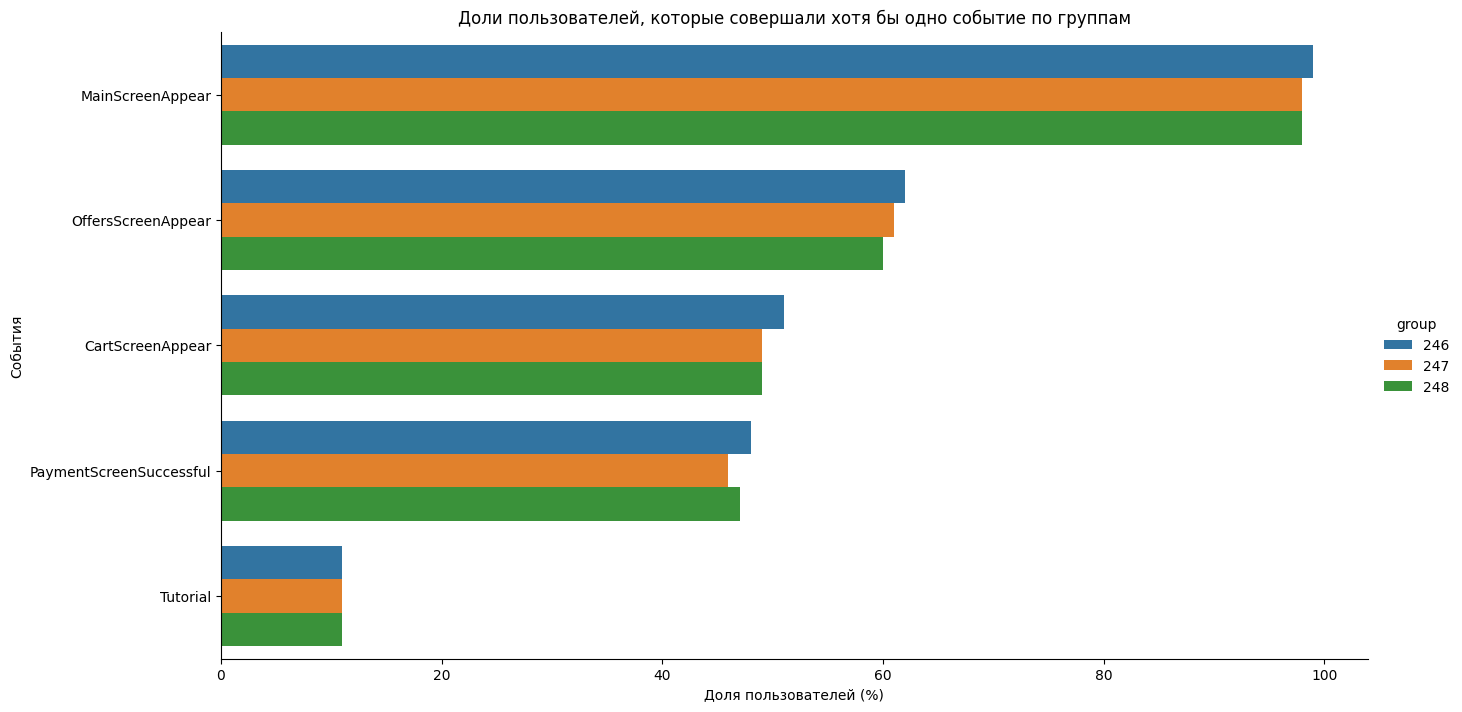

In [21]:
# визуализируем данные с разбивкой по группам:

events_bygroup = data.groupby(['event_name', 'group']).agg({'event_name':'count', 'user_id':'nunique'})
events_bygroup.columns = ['count_events', 'users']

group246 = data[data['group']==246]['user_id'].nunique()
group247 = data[data['group']==247]['user_id'].nunique()
group248 = data[data['group']==248]['user_id'].nunique()

def users_part_group(row):
    if row['group']==246:
        return (row['users']/group246 * 100)
    elif row['group']==247:
        return (row['users']/group247 * 100)
    elif row['group']==248:
        return (row['users']/group248 * 100)
events_bygroup.reset_index(inplace=True)
events_bygroup['users_part_event'] = events_bygroup.apply(users_part_group, axis=1)
events_bygroup['users_part_event'] = events_bygroup['users_part_event'].round()
events_bygroup.sort_values(by=['group', 'users'], ascending=False)

order = events_user['event_name']
sns.catplot(x='users_part_event', y='event_name', hue='group', order=order, data=events_bygroup, kind='bar', height=7, aspect=2.0)
plt.xlabel('Доля пользователей (%)')
plt.ylabel('События')
plt.title('Доли пользователей, которые совершали хотя бы одно событие по группам')
plt.show()

**Надлюдается равномерное распределение количеств событий среди трёх групп.**

Порядок совершения событий:

    1) при открытии приложения пользователь оказывается на Главной странице,
    2) затем переходит в Предложения,
    3) в Корзину,
    4) далее Оплата
    5) и, если нужно, раздел обучения.

In [22]:
# По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

display(data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False))
data_group = data.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_list()
data_group

event_name
MainScreenAppear           7423
OffersScreenAppear         4597
CartScreenAppear           3736
PaymentScreenSuccessful    3540
Tutorial                    843
Name: user_id, dtype: int64

[7423, 4597, 3736, 3540, 843]

In [23]:
print(f'Доля пользователей, зашедших в "Tutorial": {round((data_group[4]/(data_group[0]+data_group[1]+data_group[2]+data_group[3])), 2)}%')

Доля пользователей, зашедших в "Tutorial": 0.04%


**Неясно, какую пользу можно извлечь из события "Tutorial". Далее при анализе будем его игнорировать.**

In [24]:
print(f'С главной страницы в предложения перешли {round(data_group[1]/data_group[0] * 100, 2)}% пользователей.')
print(f'Из предложений в корзину перешли  {round(data_group[2]/data_group[1] * 100, 2)}% пользователей.')
print(f'К успешной оплате пришли {round(data_group[3]/data_group[2] * 100, 2)}% пользователей.')

С главной страницы в предложения перешли 61.93% пользователей.
Из предложений в корзину перешли  81.27% пользователей.
К успешной оплате пришли 94.75% пользователей.


In [25]:
# На каком шаге теряете больше всего пользователей?

print(f'При переходе с главной страницы в предложения теряется больше всего пользователей = {100 - round(data_group[1]/data_group[0] * 100, 0)}%.')

При переходе с главной страницы в предложения теряется больше всего пользователей = 38.0%.


In [26]:
# Доля пользователей, дошедших от первого события до оплаты?

print(f'Доля пользователей, которая доходит от первого события до оплаты = {round(data_group[3]/data_group[0] * 100, 1)}% .')

Доля пользователей, которая доходит от первого события до оплаты = 47.7% .


### Подытог:
    При изучении воронки событий узнали:
    
    1) Доли пользователей, совершавших каждое из событий: главный экран - их 98.5%, экран предложений - 61%, экран корзины - 49.6%, экран оплаты - 47%, руководство - 11.2%.
    2) С главной страницы в предложения перешли 61.93% пользователей.
    Из предложений в корзину перешли  81.27% пользователей.
    К успешной оплате пришли 94.75% пользователей.
    3) При переходе с главной страницы в предложения теряется больше всего пользователей = 38%.
    4) Доля пользователей, которая доходит от первого события до оплаты = 47.7%.

## Изучите результаты эксперимента

    1) Сколько пользователей в каждой экспериментальной группе?
    2) Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
    3) Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
    4) Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
    5) Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [27]:
data['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'CartScreenAppear', 'Tutorial'],
      dtype=object)

In [28]:
# Сколько пользователей в каждой экспериментальной группе:

data.groupby('group')['user_id'].nunique()

group
246    2484
247    2517
248    2537
Name: user_id, dtype: int64

_**В каждой группе около 2,5 тысяч пользователей.**_

In [29]:
# user_246 = data[data['group']==246]
# user_247 = data[data['group']==247]
# user_248 = data[data['group']==248]
# user67 = user_246.merge(user_247, left_on='user_id', right_on='user_id', how="inner", indicator=False)
# user68 = user_246.merge(user_248, left_on='user_id', right_on='user_id', how="inner", indicator=False)
# user78 = user_247.merge(user_248, left_on='user_id', right_on='user_id', how="inner", indicator=False)
# display(user67)
# display(user68)
# display(user78)

In [30]:
# Проверим пользователей, которые могли участвовать в нескольких группах одновременно:
data.groupby('user_id').agg({'group':'nunique'}).query('group > 1') 

,group
user_id,


_**Пересечений по пользователям в группах не обнаружено.**_

In [31]:
# Проверьте, находят ли статистические критерии разницу между выборками 246 и 247

g246 = data.query('group == 246')
g247 = data.query('group == 247')

group246_user = g246.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_list()
group247_user = g247.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_list()

print(group246_user,'\n', group247_user)

[2450, 1542, 1266, 1200, 278] 
 [2479, 1524, 1239, 1158, 284]


_Чтобы снизить вероятность ложноположительного результата эксперимента, к параметру alpha функции hypothesis_test применена поправка Бонферрони - когда пороговое альфа-значение делится на общее количество проверяемых нулевых гипотез._

In [32]:
df_group = data.pivot_table(index='event_name', values='user_id', columns='group',aggfunc=lambda x: len(x.unique()))
df_group = df_group.reset_index().sort_values(by=246, ascending=False).reset_index(drop=True)

def hypothesis_test(purchasesA, purchasesB, leadsA, leadsB, event_name, alpha = 0.05/16):
    
    p1 = purchasesA/leadsA
    p2 = purchasesB/leadsB

    p_combined = (purchasesA + purchasesB) / (leadsA + leadsB)
    # считаем статистику в стандартных отклонениях стандартного нормального распределения
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/leadsA + 1/leadsB))
    # задаем стандартное нормальное распределение (среднее 0, стандартное отклонение 1)
    distr = st.norm(0, 1)
    p_value =(1 - distr.cdf(abs(z_value))) * 2
    print(f'Тест для расчёта действий пользователей {event_name}')
    print('p-значение: ', p_value)

    if p_value < alpha:

        print('Отвергаем нулевую гипотезу - Между долями есть значимая разница', '\n')
    else:
        print('Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными', '\n')

test = []
for i in range(len(df_group[246])-1):
    result = hypothesis_test(
        df_group[246][i+1], 
        df_group[247][i+1], 
        df_group[246][0], 
        df_group[247][0], 
        df_group['event_name'][i], 
        alpha = 0.05
    )
    test.append(result)

Тест для расчёта действий пользователей MainScreenAppear
p-значение:  0.28974344965351984
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей OffersScreenAppear
p-значение:  0.23436481115654617
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей CartScreenAppear
p-значение:  0.11111631245768638
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей PaymentScreenSuccessful
p-значение:  0.9039224227191858
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 



**Выяснилось, что статистические критерии не находят разницу между выборками 246 и 247.**

In [33]:
#срезаем незначительное событие:

data = data[data['event_name'] != 'Tutorial']
df_group = df_group[df_group['event_name'] != 'Tutorial']

In [34]:
# Выберите самое популярное событие

df_group.style.highlight_max()
df_group['246/247'] = 1 - (df_group[246]/ df_group[247])
df_group = df_group.reset_index()
df_group

group,index,event_name,246,247,248,246/247
0,0,MainScreenAppear,2450,2479,2494,0.011698
1,1,OffersScreenAppear,1542,1524,1531,-0.011811
2,2,CartScreenAppear,1266,1239,1231,-0.021792
3,3,PaymentScreenSuccessful,1200,1158,1182,-0.036269


**В каждой группе самое популярное событие - _Переход на главный экран_**

### Гипотезы
    Н0 - в значениях групп 246 и 247 нет существенной разницы.
    Н1 - в значениях групп 246 и 247 есть существенная разница. 

In [42]:
figur = go.Figure()

figur.add_trace(go.Funnel(name = '246 group',
    y = df_group["event_name"],
    x = df_group[246],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#39A608"}))

figur.add_trace(go.Funnel(name = '247 group',
    y = df_group["event_name"],
    x = df_group[247],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#2C4791"}))
figur.update_layout(title='Распределение количества пользователей по событиям в группах 246 и 247',height=700, width=1100)
figur.show()

In [43]:
# тест:

tst = [hypothesis_test(df_group[246][i],df_group[247][i],df_group[246].sum(),
                    df_group[247].sum(),df_group['event_name'][i], alpha =  0.01) for i in range(len(df_group[246]))]

Тест для расчёта действий пользователей MainScreenAppear
p-значение:  0.35273029774368636
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей OffersScreenAppear
p-значение:  0.9312311695164079
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей CartScreenAppear
p-значение:  0.7266425345832479
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей PaymentScreenSuccessful
p-значение:  0.4747685576025602
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 



**Контрольные группы сформированы корректно - "Нет оснований считать доли разными"**

### Гипотезы
    Н0 - в значениях групп 247 и 248 нет существенной разницы.
    Н1 - в значениях групп 247 и 248 есть существенная разница. 

In [44]:
# тест:

tst1 = [hypothesis_test(df_group[248][i],df_group[247][i],df_group[248].sum(),
                    df_group[247].sum(),df_group['event_name'][i], alpha =  0.05) for i in range(len(df_group[248]))]

Тест для расчёта действий пользователей MainScreenAppear
p-значение:  0.9959509559248529
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей OffersScreenAppear
p-значение:  0.9662307930256859
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей CartScreenAppear
p-значение:  0.7317368027910043
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей PaymentScreenSuccessful
p-значение:  0.6963026616244683
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 



**Так как "Нет оснований считать доли разными", можно констатировать, что группы 247 и 248 сформированы корректно.**

In [45]:
# Аналогично поступите с группой с изменённым шрифтом.
# Сравните результаты с каждой из контрольных групп в отдельности по каждому событию.
# Сравните результаты с объединённой контрольной группой.

figur1 = go.Figure()

figur1.add_trace(go.Funnel(name = '246 group',
    y = df_group["event_name"],
    x = df_group[246],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#39A608"}))
figur1.add_trace(go.Funnel(name = '247 group',
    y = df_group["event_name"],
    x = df_group[247],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#FFFD95"}))
figur1.add_trace(go.Funnel(name = '248 group',
    y = df_group["event_name"],
    x = df_group[248],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#2C4791"}))

figur1.update_layout(title='Распределение количества пользователей по событиям в группах 246, 247, 248',height=700, width=1100)
figur1.show()

### Гипотезы
    Н0 - в значениях групп 246 и 248 нет существенной разницы.
    Н1 - в значениях групп 246 и 248 есть существенная разница. 

In [46]:
# тест:

tst2 = [hypothesis_test(df_group[248][i],df_group[246][i],df_group[248].sum(),
                    df_group[246].sum(),df_group['event_name'][i], alpha =  0.05) for i in range(len(df_group[248]))]

Тест для расчёта действий пользователей MainScreenAppear
p-значение:  0.3493928459684199
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей OffersScreenAppear
p-значение:  0.8974717214906709
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей CartScreenAppear
p-значение:  0.4878751132108463
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей PaymentScreenSuccessful
p-значение:  0.7454624679658486
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 



**Тест не определил существенную разницу между группами 246 и 248.**

### Гипотезы
    Н0 - в значениях групп 248 и объединённых контрольных группах нет существенной разницы.
    Н1 - в значениях групп 248 и объединённых контрольных группах есть существенная разница. 

In [47]:
figur2 = go.Figure()

figur2.add_trace(go.Funnel(name = "248 group",
    y = df_group["event_name"],
    x = df_group[248],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#39A600"}))

figur2.add_trace(go.Funnel(name = "246 и 247 groups",
    y = df_group["event_name"],
    x = df_group[247]+df_group[246],textposition = "inside", 
    textinfo = "value+percent previous",
    marker = {"color": "#2C4791"}))

figur2.update_layout(title='Распределение количества пользователей по событиям в объединённых контрольных группах и экспериментальной ',height=700, width=1100)
figur2.show()

In [48]:
# тест:

tst3 = [hypothesis_test(df_group[248][i],df_group[246][i]+df_group[247][i],df_group[248].sum(),
                    (df_group[246]+df_group[247]).sum(),df_group['event_name'][i], alpha =  0.05) for i in range(len(df_group[248]))]

Тест для расчёта действий пользователей MainScreenAppear
p-значение:  0.5859390798679431
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей OffersScreenAppear
p-значение:  0.9211267237985354
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей CartScreenAppear
p-значение:  0.5493605183790484
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 

Тест для расчёта действий пользователей PaymentScreenSuccessful
p-значение:  0.9717026765618824
Не получилось отвергнуть нулевую гипотезу - Нет оснований считать доли разными 



**По результатам теста существенной разницы между экспериментальной и контрольными группами нет.**

### Подытог:

_**Проводимые тесты не выявили разницу между имеющимися контрольными группами и экспериментальной - Шрифт не влияет на пользователей.**_

## Вывод

    1) При проверке данных мы узнали, что изначально в таблице было 243’713 событий от 7’551 пользователя, а в среднем на одного пользователя приходилось 20 событий.

	Далее мы выявили, что к анализу допустим период с 31 июля с 21:00 по 7 августа. Мы не взяли во внимание данные с 25 июля по 31 июля до 21:00, что привело к незначительным потерям событий — 0.82%.

	В каждой группе около 2’500 пользователей.
    
	
	2) Изучение воронки событий:
    
    Доли пользователей, совершавших каждое из событий: главный экран - их 98.5%, экран предложений - 61%, экран корзины - 49.6%, экран оплаты - 47%, руководство - 11.2%.

    С главной страницы в предложения перешли 61.93% пользователей.
    Из предложений в корзину перешли  81.27% пользователей.
    К успешной оплате пришли 94.75% пользователей.

    При переходе с главной страницы в предложения теряется больше всего пользователей = 38%.
    
    Доля пользователей, которая доходит от первого события до оплаты = 47.7%.
    

	3) А/А/B - тесты:
    
    Было проведено 16 тестов:
    - 246/247 - 4 теста - уровень статистической значимости - 1%
    - 246/248 - 4 теста - уровень статистической значимости - 5%
    - 247/248 - 4 теста - уровень статистической значимости - 5%
    - (246+247)/248 - 4 теста - уровень статистической значимости - 5%
    
    Для проведения A/A тестирования был взят уровень статистической значимости в 1%. По его результатам для всех событий разница не оказалось значимой - эти группы контрольные.

    Уровень статистической значимости в 10% был бы велик - каждый десятый раз можно получать ложный результат, поэтому стоит применить уровень значимости - 0.05.

    В результате всех и каждого A/A/B тестов значимой разницы между группами не выявлено. Можно утверждать, что на поведение пользователей изменение шрифта значительно не сказалось.

_**Тестирование считаем успешным - изменение шрифта не повлияло на поведение пользователей.**_